In [1]:
import sys
sys.path[0] = ('/home/labs/waic/omrik/DNN-Challenge')
from fastai.vision import *
import pre
import resample

root = Path('../data').resolve()
train = root / 'train'
val = root / 'val'

In [2]:
def normalize_time(series):
    # 1440 minutes in a day
    normalized = (series.hour * 60 + series.minute) / 1440
    return normalized

def get_data(data_dir):
    cgm, meals = pre.get_dfs(data_dir)
    meals = resample.resample_meals(cgm, meals, 15)
    meals = pd.concat((meals, cgm), axis=1)
    meals['time'] = normalize_time(meals.index.get_level_values('Date'))
    cgm, y = pre.build_cgm(cgm)
    return cgm, meals, y

class ContData(Dataset):
    def __init__(self, cgm, meals, y):
        self.cgm = cgm
        self.meals = meals
        self.y = y
        
    def __len__(self):
        return len(self.cgm)
    
    def __getitem__(self, i):
        index = self.meals.index.get_loc(self.cgm.index[i])
        values = self.meals[index-48:index+1].values
        target = self.y.iloc[i].values
        x, y = torch.tensor(values, dtype=torch.float), torch.tensor(target, dtype=torch.float)
        return x, y
    
class AddNoise(Callback):
    _order = 0
    
    def __init__(self, std):
        self.std = std
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if not train:
            return
        
        size = last_input.shape[0], last_input.shape[2]
        noise = torch.normal(0, self.std, size).to(last_input.device)
        last_input[:, -2] += noise
        return {'last_input': last_input}


In [3]:
train_data = get_data(train)
val_data = get_data(val)

/home/labs/waic/omrik/DNN-Challenge/pre.py:73: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  X = X.loc[y.index].dropna(how='any', axis=0)


In [4]:
train_ds = ContData(*train_data)
val_ds = ContData(*val_data)
data = DataBunch.create(train_ds, val_ds, bs=512)
data

DataBunch;

Train: <__main__.ContData object at 0x7fc25156d748>;

Valid: <__main__.ContData object at 0x7fc25156d978>;

Test: None

In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

    

class TransformerModel(Module):
    def __init__(self, pos_dropout=0., d_model=512, nhead=8, nlayers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        encoder_norm = nn.LayerNorm(d_model)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, nlayers, encoder_norm)
        
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        decoder_norm = nn.LayerNorm(d_model)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, nlayers, decoder_norm)
        
        self.d_model = d_model
        self.input_embedding = nn.Linear(38, self.d_model)
        self.output_embedding = nn.Linear(1, self.d_model)
        self.pos_encoder = PositionalEncoding(self.d_model, pos_dropout)
        self.decoder = nn.Linear(self.d_model, 1)
        
    def one_iter(self, mem, tgt, mask):
        tgt = self.output_embedding(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)
        
        output = self.transformer_decoder(tgt, mem, tgt_mask=mask)
        
        output = self.decoder(output)
        output = output
        return output
    
    @staticmethod
    def generate_square_subsequent_mask(sz):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, train):
        src = src.transpose(0, 1)
        src = self.input_embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        mem = self.transformer_encoder(src)
        
        sos = tgt.new_zeros((tgt.shape[0], 1))
        tgt = torch.cat((sos, tgt), dim=1)
        tgt = tgt.T.unsqueeze(-1)[:-1]
        
        mask = self.generate_square_subsequent_mask(tgt.shape[0]).to(tgt.device)
        if train:
            out = self.one_iter(mem, tgt, mask)
            return out.squeeze().T
        
        tgt = tgt.new_zeros((9, tgt.shape[1], 1))
        for i in range(8):
            tgt[i+1] = self.one_iter(src, tgt[:-1], mask)[i]
        
        out = tgt[:-1]
        return out.squeeze().T
        

class TransformerCallback(Callback):
    _order = 5
    
    def __init__(self):
        super().__init__()
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        return {'last_input': (last_input, last_target, train)}


In [6]:
from metrics import Pearson

model = TransformerModel(d_model=128, nhead=2, nlayers=2, dim_feedforward=256)
metrics = [mean_absolute_error, Pearson(val_ds.y)]
callbacks = [AddNoise(0.1), TransformerCallback()]
learner = Learner(data, model, loss_func=nn.MSELoss(), callbacks=callbacks, metrics=metrics)

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04
Min loss divided by 10: 1.91E-03


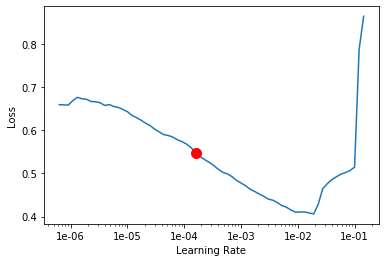

In [7]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [8]:
learner.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time
0,0.120647,0.951214,0.724910,-0.001176,02:32
1,0.108518,1.011085,0.751991,0.003178,02:31
2,0.094985,1.131163,0.803658,0.017759,02:31
3,0.086103,1.282959,0.754938,-0.067548,02:33
